In [119]:
import torch
import torch.nn as nn
import pandas as pd

# 1. ViT

In [120]:
BATCH_SIZE = 120
PATCH_SIZE = 4
EMB_DIM = 192

IMG_SIZE = 28
IMG_DEPTH = 1
NUM_CLASSES = 10

NUM_HEADS = 4
HIDDEN_DIM = 768
DROP_OUT_RATE = 0.3

WD = 0
LR = 2e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CSV_PATH = "./data/train.csv"

In [121]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, img_size, in_channel, emb_dim):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.in_channel = in_channel
        self.emb_dim = emb_dim

        self.emb_layer = self._embadding_layer()

        num_patch = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_emb = nn.Parameter(torch.randn(1, num_patch + 1, emb_dim))

    def _embadding_layer(self):
        return nn.Sequential(
            nn.Conv2d(kernel_size=self.patch_size, stride=self.patch_size,
                      in_channels=self.in_channel, out_channels=self.emb_dim),
            # (B, EMB_DIM, img_size / PATCH_SIZE , img_size / PATCH_SIZE)
            nn.Flatten(start_dim=2) 
            # (B, EMB_DIM, 49)
        )

    def forward(self, x):
        x = self.emb_layer(x).transpose(1,2)

        cls_tokens = self.cls_token.expand(BATCH_SIZE, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # (B, 50, EMB_DIM)
        x = x + self.pos_emb
        return x

In [122]:
class ViT(nn.Module):
    def __init__(self, emb_dim, num_heads, hidden_dim, drop_out_rate, 
                 img_size, patch_size, in_channels, num_classes):
        super().__init__()
        self.emb_dim = emb_dim        
        self.num_heads = num_heads
        self.droptout = drop_out_rate
        self.hidden_dim = hidden_dim

        self.embedding = PatchEmbedding(patch_size=patch_size, img_size=img_size, 
                                        in_channel=in_channels, emb_dim=emb_dim)
        self.encoder = self._make_encoder_layers()
        self.norm = nn.LayerNorm(emb_dim)
        self.mlp_head = nn.Linear(emb_dim, num_classes)
    
    def _make_encoder_layers(self):
        return nn.Sequential(
            nn.TransformerEncoderLayer(d_model=self.emb_dim, nhead=self.num_heads,
                                       dim_feedforward=self.hidden_dim, 
                                       dropout=self.droptout,
                                       batch_first=True),
            # nn.TransformerEncoderLayer(d_model=self.emb_dim, nhead=self.num_heads,
            #                            dim_feedforward=self.hidden_dim, 
            #                            dropout=self.droptout,
            #                            batch_first=True)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.norm(x)
        # (B, 50, EMB_DIM)
        cls_token = x[:, 0, :] # (B, EMB_DIM)
        return self.mlp_head(cls_token)

# 2. Dataset

In [123]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        label = int(row['label'])
        pixels = torch.tensor(row.iloc[1:].values, dtype=torch.float32)
        image = pixels.view(1, 28, 28) 

        return image, label

In [124]:
from torch.utils.data import random_split

dataset = Dataset(CSV_PATH)
print(len(dataset))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

42000


In [125]:
# Test
test_vit = ViT(EMB_DIM, NUM_HEADS, HIDDEN_DIM, DROP_OUT_RATE, IMG_SIZE, PATCH_SIZE, 
          in_channels=IMG_DEPTH, num_classes=NUM_CLASSES)

loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for image, label in loader:
    out = test_vit(image)
    break

# 3. Train

In [126]:
EPOCHS = 500

In [127]:
from tqdm import tqdm
from tqdm import trange

In [128]:
def train_fn(train_loader, model, optimizer, loss_fn, show_progress=False):
    loop = tqdm(train_loader, leave=True) if show_progress else train_loader
    losses = []

    for _, (img, label) in enumerate(loop):
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        out = model(img)

        loss = loss_fn(out, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if show_progress:
            loop.set_postfix(loss=loss.item())

    mean_loss = sum(losses) / len(losses)
    return mean_loss


In [129]:
def validate(loader, model, loss_fn, show_progress=False):
    model.eval()
    loop = tqdm(loader, leave=True) if show_progress else loader
    losses = []

    with torch.no_grad():
        for _, (img, label) in enumerate(loop):
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            out = model(img)
            loss = loss_fn(out, label)
            losses.append(loss.item())

            if show_progress:
                loop.set_postfix(loss=loss.item())

    mean_loss = sum(losses) / len(losses)
    model.train()
    return mean_loss


In [130]:
model = ViT(EMB_DIM, NUM_HEADS, HIDDEN_DIM, DROP_OUT_RATE, IMG_SIZE, PATCH_SIZE, 
          in_channels=IMG_DEPTH, num_classes=NUM_CLASSES)
model = model.to(DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
loss = nn.CrossEntropyLoss()

In [131]:
small_dataset, val_small_dataset, _ = random_split(dataset, [3000, 600, len(dataset) - 3600])
small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_small_loader = torch.utils.data.DataLoader(val_small_dataset, batch_size=BATCH_SIZE, shuffle=True)

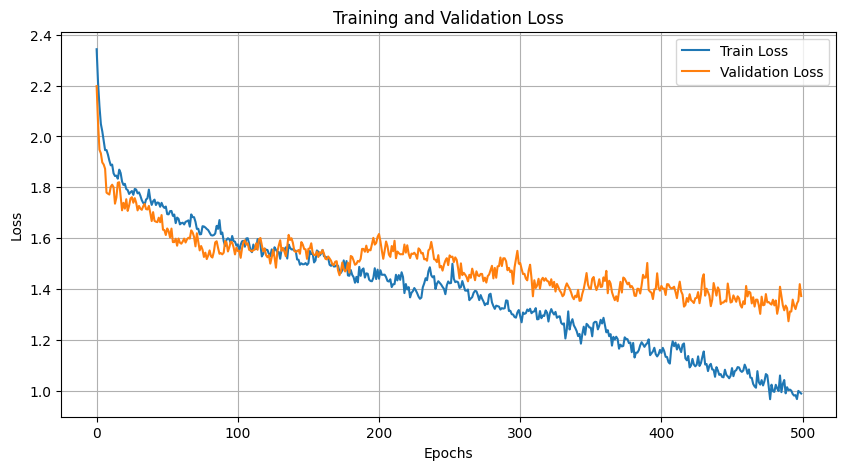

Training: 100%|██████████| 500/500 [05:33<00:00,  1.50it/s]


In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_path = None

for epoch in trange(EPOCHS, desc="Training"):
    for x, y in small_loader:
        x = x.to(DEVICE)

    train_loss = train_fn(small_loader, model, optim, loss)
    val_loss = validate(val_small_loader, model, loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"best_model_epoch{epoch + 1}.pt")
        if best_model_path is not None and os.path.exists(best_model_path):
            os.remove(best_model_path)
        best_model_path = f"best_model_epoch{epoch + 1}.pt"

    # ✅ Live plot in Jupyter
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
